In [ ]:
!nvidia-smi

Sat Sep 16 07:36:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive'

MyDrive  Shareddrives


In [ ]:
train_path = '/content/drive/MyDrive/bodybuilder1/train'
test_path = '/content/drive/MyDrive/bodybuilder1/test'
val_path = '/content/drive/MyDrive/bodybuilder1/valid'

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.keras.layers.Input
tf.keras.layers.Lambda
tf.keras.layers.Dense
tf.keras.layers.Flatten
tf.keras.models.Model
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import preprocess_input
tf.keras.preprocessing.image
tf.keras.preprocessing.image.ImageDataGenerator
tf.keras.models.Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import os

import random

import pandas as pd
import seaborn as sns

In [ ]:
class_labels = sorted(os.listdir(train_path))
class_labels

['non_steroid', 'steroid']

In [ ]:
directories = os.listdir(train_path)
image_steroid = []
image_non_steroid = []
class_images = []

for d in directories:
    image_paths = train_path + '/' + d + '/*.jpg'
    image_files = glob(image_paths)
    for i in range(5):
        if d == 'steroid':
            image_steroid.append(plt.imread(image_files[random.randint(0, len(image_files) - 1)]))
        else:
            image_non_steroid.append(plt.imread(image_files[random.randint(0, len(image_files) - 1)]))
    class_images.append(image_files)

In [ ]:
plt.figure(figsize=(20,25))

count = 0
offset = 1

while count < len(image_steroid):
    plt.subplot(5,2,count+offset)
    # image = batch[0]
    plt.imshow(np.squeeze(image_steroid[count]))
    plt.title('steroid')
    plt.subplot(5,2,count+offset+1)
    # image = batch[0]
    plt.imshow(np.squeeze(image_non_steroid[count]))
    plt.title('non_steroid')

    count += 1
    offset += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_image_count = []

for i in class_images:
    train_image_count.append(len(i))

train_image_count

[1565, 1549]

In [ ]:
directories = os.listdir(test_path)
test_image_count = []

for d in directories:
    image_paths = test_path + '/' + d + r'/*.jpg'
    image_files = glob(image_paths)
    test_image_count.append(len(image_files))

test_image_count

[392, 279]

In [ ]:
directories = os.listdir(val_path)
val_image_count = []

for d in directories:
    image_paths = val_path + '/' + d + r'/*.jpg'
    image_files = glob(image_paths)
    val_image_count.append(len(image_files))

val_image_count

[257, 297]

In [ ]:
dataset_info = pd.DataFrame({'Label': class_labels, 'Train_Count': train_image_count, 'Test_Count': test_image_count, 'Val_Count': val_image_count})
dataset_info

,Label,Train_Count,Test_Count,Val_Count
0,non_steroid,1565,392,257
1,steroid,1549,279,297


In [ ]:
df = pd.melt(dataset_info, id_vars='Label', var_name='Split', value_name="Count")
df

,Label,Split,Count
0,non_steroid,Train_Count,1565
1,steroid,Train_Count,1549
2,non_steroid,Test_Count,392
3,steroid,Test_Count,279
4,non_steroid,Val_Count,257
5,steroid,Val_Count,297


<Figure size 2000x800 with 0 Axes>

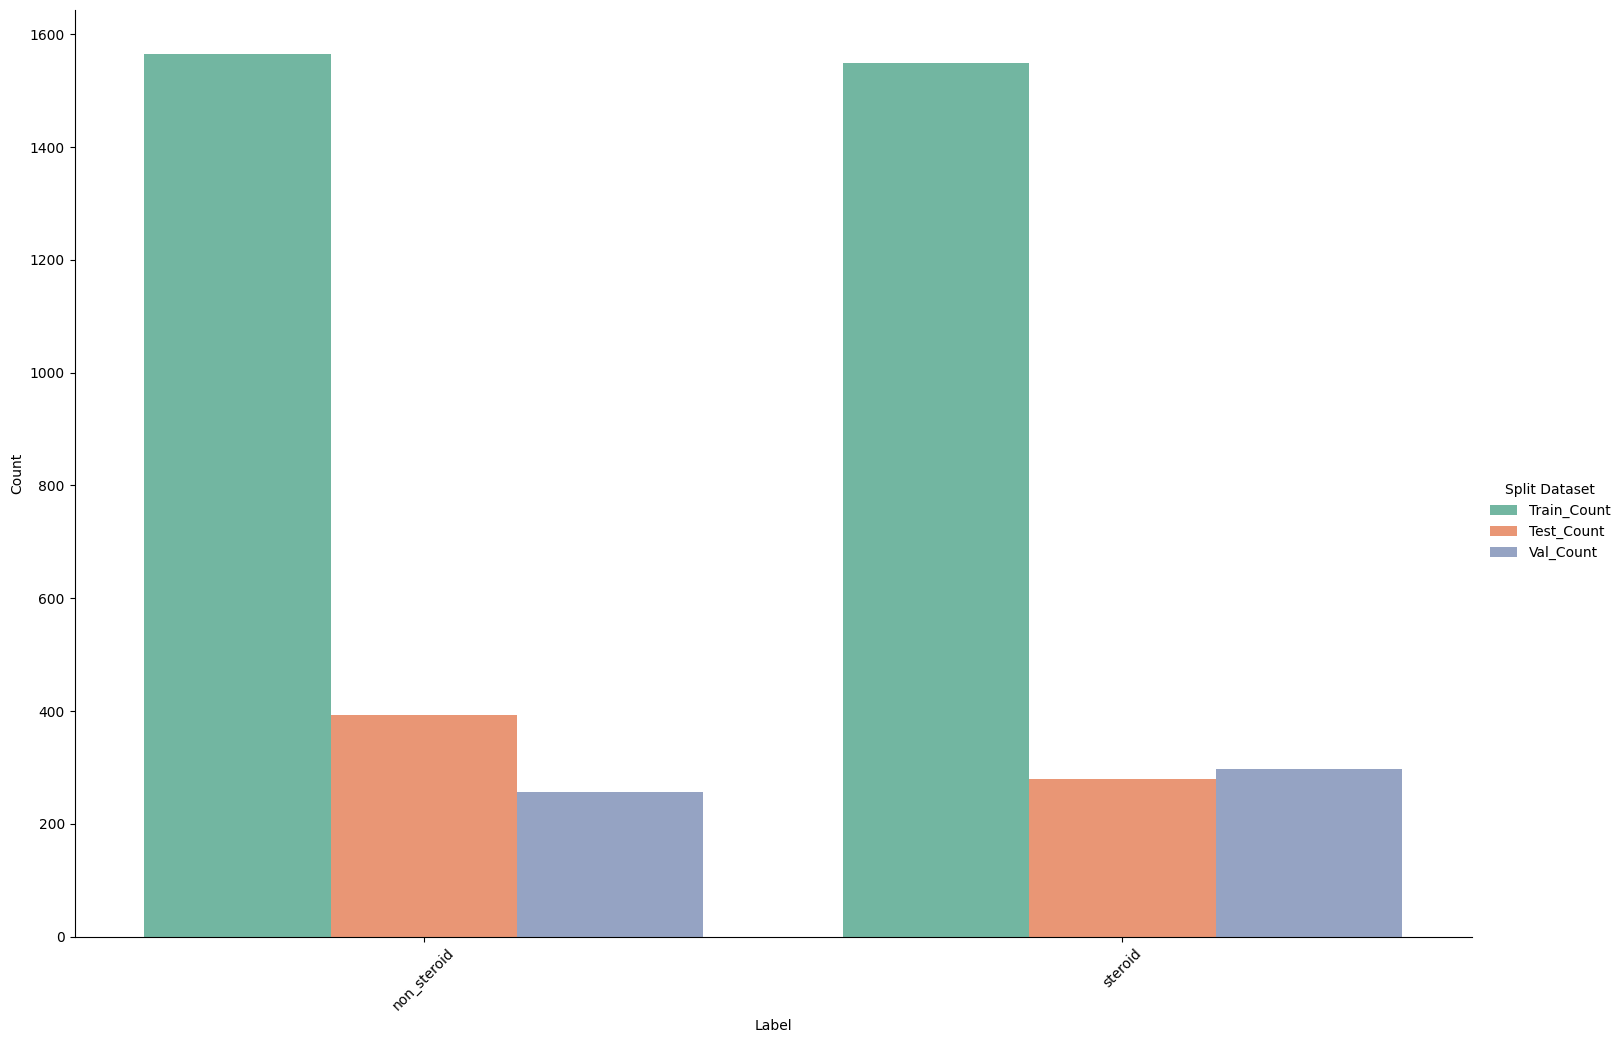

In [ ]:
plt.figure(figsize=(20, 8))

g = sns.catplot(
    data=df, kind='bar',
    x='Label', y='Count', hue='Split', palette='Set2', height=10, aspect=1.5)

plt.xticks(rotation=45)
g.set_axis_labels('Label', 'Count')
g.legend.set_title('Split Dataset')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (244, 244)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3114 files belonging to 2 classes.
Found 554 files belonging to 2 classes.
Found 671 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(244, 244, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 244, 244, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 244, 244, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 244, 244, 3)          0         ['normalization[0

In [ ]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

18/18 [==============================] - 66s 1s/step - loss: 0.8241 - accuracy: 0.3700
initial loss: 0.82
initial accuracy: 0.37


In [ ]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset)

Epoch 1/30
98/98 [==============================] - 543s 5s/step - loss: 0.7291 - accuracy: 0.4881 - val_loss: 0.6278 - val_accuracy: 0.6173
Epoch 2/30
98/98 [==============================] - 16s 159ms/step - loss: 0.5737 - accuracy: 0.6715 - val_loss: 0.4997 - val_accuracy: 0.7834
Epoch 3/30
98/98 [==============================] - 16s 158ms/step - loss: 0.4757 - accuracy: 0.7868 - val_loss: 0.4146 - val_accuracy: 0.8412
Epoch 4/30
98/98 [==============================] - 16s 157ms/step - loss: 0.4067 - accuracy: 0.8330 - val_loss: 0.3553 - val_accuracy: 0.8935
Epoch 5/30
98/98 [==============================] - 16s 155ms/step - loss: 0.3591 - accuracy: 0.8661 - val_loss: 0.3122 - val_accuracy: 0.9134
Epoch 6/30
98/98 [==============================] - 17s 162ms/step - loss: 0.3222 - accuracy: 0.8834 - val_loss: 0.2800 - val_accuracy: 0.9206
Epoch 7/30
98/98 [==============================] - 16s 154ms/step - loss: 0.2941 - accuracy: 0.9008 - val_loss: 0.2551 - val_accuracy: 0.9314
E

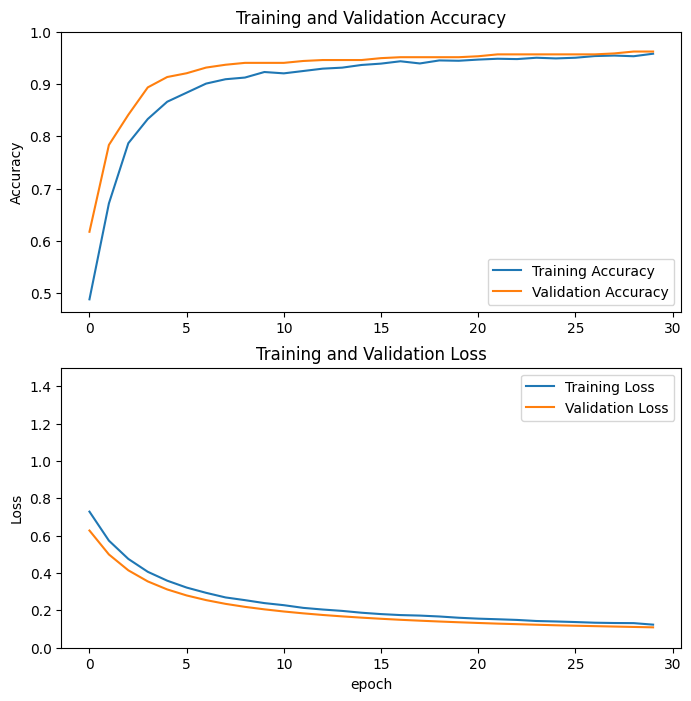

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers:
  layer.trainable = True

Number of layers in the base model:  238


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
              metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/60
98/98 [==============================] - 72s 352ms/step - loss: 0.1219 - accuracy: 0.9560 - precision: 0.9824 - recall: 0.9291 - val_loss: 0.1010 - val_accuracy: 0.9657 - val_precision: 0.9958 - val_recall: 0.9300
Epoch 31/60
98/98 [==============================] - 31s 312ms/step - loss: 0.1137 - accuracy: 0.9611 - precision: 0.9859 - recall: 0.9361 - val_loss: 0.0948 - val_accuracy: 0.9657 - val_precision: 0.9958 - val_recall: 0.9300
Epoch 32/60
98/98 [==============================] - 32s 318ms/step - loss: 0.1047 - accuracy: 0.9615 - precision: 0.9859 - recall: 0.9367 - val_loss: 0.0891 - val_accuracy: 0.9657 - val_precision: 0.9958 - val_recall: 0.9300
Epoch 33/60
98/98 [==============================] - 32s 319ms/step - loss: 0.0978 - accuracy: 0.9644 - precision: 0.9873 - recall: 0.9412 - val_loss: 0.0845 - val_accuracy: 0.9657 - val_precision: 0.9958 - val_recall: 0.9300
Epoch 34/60
98/98 [==============================] - 33s 319ms/step - loss: 0.0938 - accuracy: 0

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

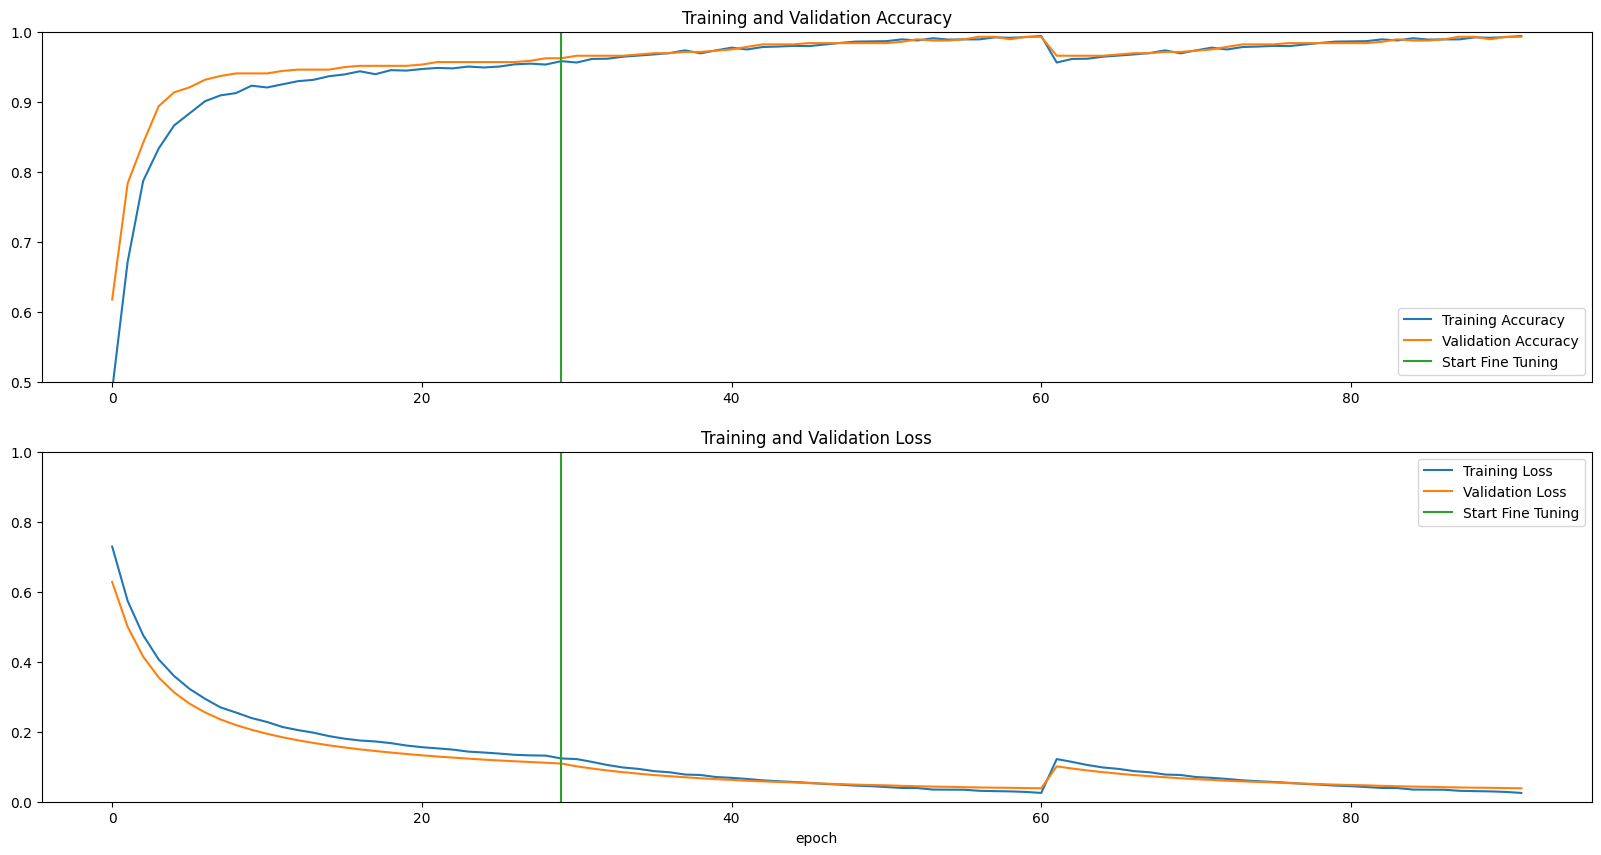

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss= model.evaluate(test_dataset)
accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

21/21 [==============================] - 3s 101ms/step - loss: 0.0437 - accuracy: 0.9806 - precision: 0.9822 - recall: 0.9847
Test accuracy : [0.04368811845779419, 0.9806259274482727, 0.9821882843971252, 0.9846938848495483]


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 25))
for i in range(28):
  ax = plt.subplot(7, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('Predicted: '+ class_names[predictions[i]] + '    True: ' + class_names[label_batch[i]])
  plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

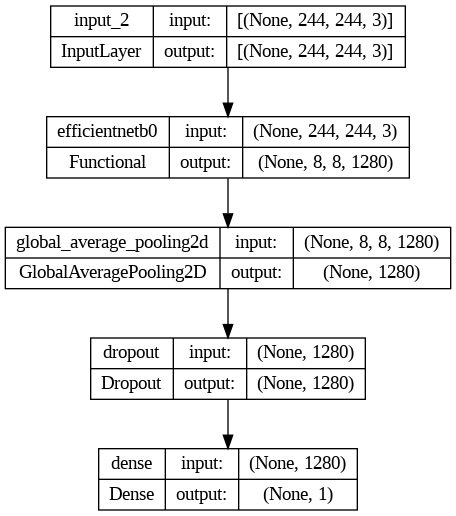

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
model.save('buildEfficientFinal.h5')

In [ ]:
predict = np.array([])
l =  np.array([])
for x, y in test_dataset:
  p = model.predict(x).flatten()
  p = tf.nn.sigmoid(p)
  p = tf.where(p < 0.5, 0, 1)
  predict = np.concatenate([predict, p])
  l = np.concatenate([l, y])

1/1 [==============================] - 1s 1s/step


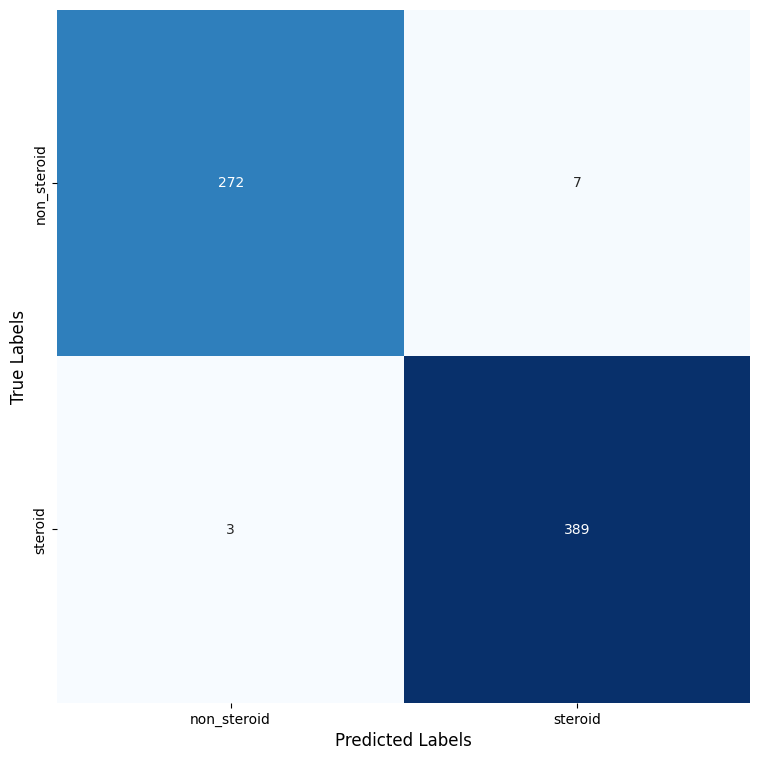

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(l, predict)

plt.figure(figsize=(10,9))
sns.heatmap(cm, annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d',
           cmap=plt.cm.Blues, cbar=False)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
for x, y in test_dataset:
  y_pred = model.predict(x).ravel()
  fpr_k, tpr_keras, thresholds = roc_curve(y, y_pred)

1/1 [==============================] - 0s 56ms/step


In [ ]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)


rf.fit(X_train, y_train)

for x,y in test_dataset:
  y_pred_rf = rf.predict(x)[:, 1]
  fpr_rf, tpr_rf, thresholds_rf = roc_curve(y, y_pred_rf)
  auc_rf = auc(fpr_rf, tpr_rf)

ValueError: ignored

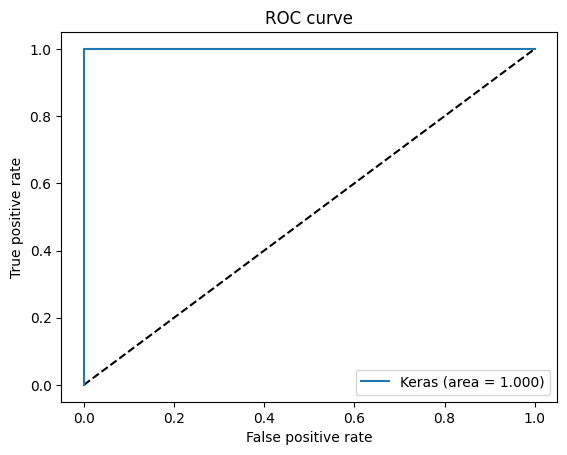

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.


In [ ]:
from sklearn.metrics import classification_report
# Classification Report
report = classification_report(l, predict, target_names=class_names)
print(report)

              precision    recall  f1-score   support

 non_steroid       0.99      0.97      0.98       279
     steroid       0.98      0.99      0.99       392

    accuracy                           0.99       671
   macro avg       0.99      0.98      0.98       671
weighted avg       0.99      0.99      0.99       671

